In [1]:
import os
import gc
#import jovian

import numpy as np 
import pandas as pd

from pathlib import Path

from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

## Data Preparation

In [2]:
!ls ../input

ls: cannot access '../input': No such file or directory


In [3]:
data_folder = Path('/home/ubuntu/datasets/severstal-steel-defect-detection/')
train_images = data_folder / 'train_images'
test_images = data_folder / 'test_images'

In [4]:
# use fastai function to get the training images
fnames = get_image_files(train_images)
fnames[:3]

[PosixPath('/home/ubuntu/datasets/severstal-steel-defect-detection/train_images/10e429bfc.jpg'),
 PosixPath('/home/ubuntu/datasets/severstal-steel-defect-detection/train_images/c4d5657bc.jpg'),
 PosixPath('/home/ubuntu/datasets/severstal-steel-defect-detection/train_images/2a351164a.jpg')]

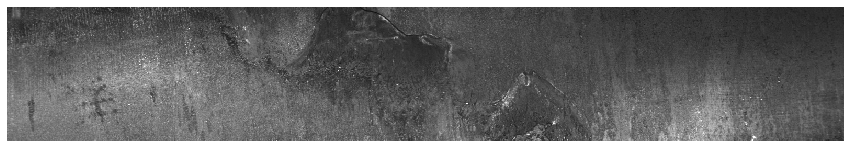

In [5]:
# take a look at the one of the training images
# - choosing an image that has defects on the matching mask
img_f = train_images/'000f6bf48.jpg'
img = open_image(img_f)
img.show(figsize=(15,3))

## Use pre-made segmentation masks

Using pre-created segmentation masks that were made using this notebook:

https://www.kaggle.com/nikhilikhar/steel-create-labels?scriptVersionId=18640338

In [6]:
# ! apt install  -y unzip 
# ! mkdir -p ../labels/
# ! unzip -q ../input/steel-create-labels/labels-img.zip -d ../labels/

In [7]:
path_lbl = Path('/home/ubuntu/datasets/severstal-steel-defect-detection/labels-img/')

https://forums.fast.ai/t/unet-segmentation-mask-converter-to-help-against-common-errors-problems/42949

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/ubuntu/datasets/severstal-steel-defect-detection/labels-img/ccbeeb18a.png'),
 PosixPath('/home/ubuntu/datasets/severstal-steel-defect-detection/labels-img/4598f8be0.png'),
 PosixPath('/home/ubuntu/datasets/severstal-steel-defect-detection/labels-img/b162a9cb2.png')]

In [9]:
def get_y_fn(x):
    x = Path(x)
    return path_lbl/f'{x.stem}.png'

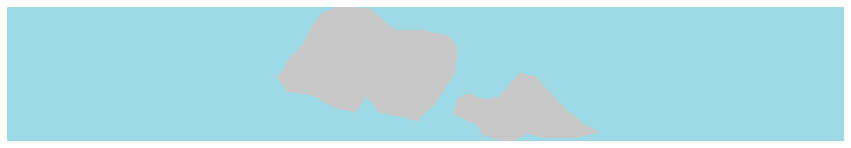

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(15,3), alpha=1)

In [11]:
train_df = pd.read_csv(data_folder / 'train.csv')
train_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [12]:
# get the training image with the most defects
train_df.ImageId.mode()

0    db4867ee8.jpg
1    ef24da2ba.jpg
dtype: object

In [13]:
# get all the rows belonging to the image with the most defects
most_defects = train_df.loc[train_df['ImageId'] == "db4867ee8.jpg"]
most_defects

,ImageId,ClassId,EncodedPixels
6101,db4867ee8.jpg,1,349941 2 350194 6 350447 11 350700 15 350953 1...
6102,db4867ee8.jpg,2,354411 17 354634 50 354857 82 355096 99 355351...
6103,db4867ee8.jpg,3,233729 3008 236801 64


In [14]:
train_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


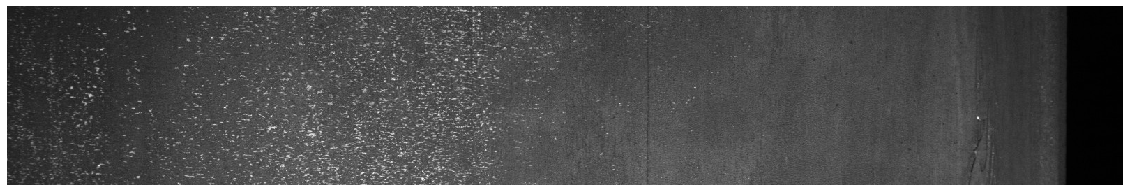

In [15]:
img_f = train_images/"db4867ee8.jpg"
img = open_image(img_f)
img.show(figsize=(20,10))

In [16]:
open_mask?

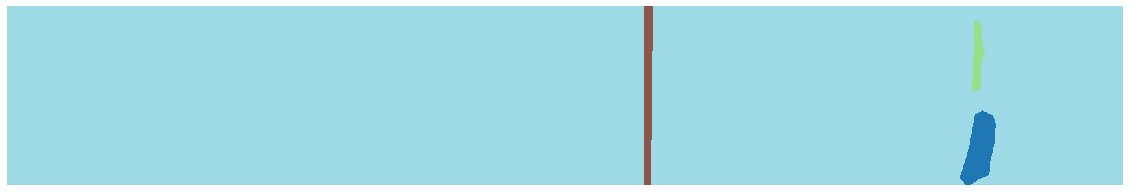

In [17]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(20,10), alpha=1)

In [18]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([ 256, 1600]),
 tensor([[[4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4],
          ...,
          [4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4]]]))

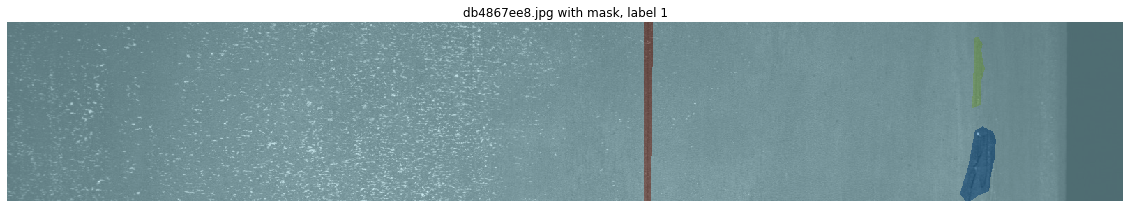

In [19]:
img.show(y=mask, figsize=(20, 10), title=f"{img_f.name} with mask, label 1")

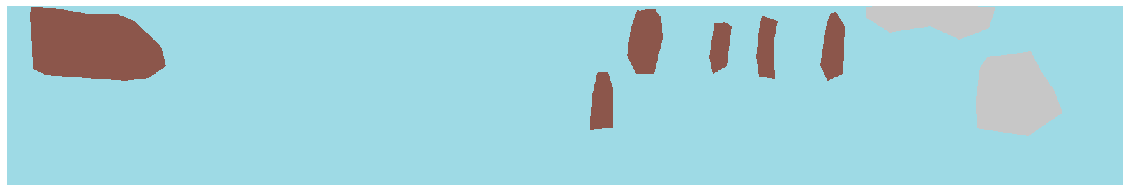

In [20]:
# premade mask
mask = open_mask(get_y_fn("0025bde0c.jpg"))
mask.show(figsize=(20,10), alpha=1)

In [21]:
mask.shape

torch.Size([1, 256, 1600])

In [22]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([ 256, 1600]),
 tensor([[[4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4],
          ...,
          [4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4]]]))

In [23]:
from fastai.utils.mem import *
free = gpu_mem_get_free_no_cache()

# the max size of bs depends on the available GPU RAM
# if free > 8200: batch_size=16
# else:           batch_size=4
# print(f"using bs={batch_size}, have {free}MB of GPU RAM free")

batch_size=8

In [24]:
codes = ['0','1','2','3','4']

# half the size of the images
size = src_size//2
size

array([128, 800])

In [25]:
# need to define a function that does nothing to get around a problem in Fastai
# when adding the test images to the DataBunch
def no_tfms(self, x, **kwargs): return x
EmptyLabel.apply_tfms = no_tfms

In [26]:
src = (SegmentationItemList.from_df(train_df, train_images)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes)
       .add_test_folder(test_images, label=None))
src

LabelLists;

Train: LabelList (5676 items)
x: SegmentationItemList
Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600)
y: SegmentationLabelList
ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600)
Path: /home/ubuntu/datasets/severstal-steel-defect-detection/train_images;

Valid: LabelList (1419 items)
x: SegmentationItemList
Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600)
y: SegmentationLabelList
ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600)
Path: /home/ubuntu/datasets/severstal-steel-defect-detection/train_images;

Test: LabelList (5506 items)
x: SegmentationItemList
Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600)
y: EmptyLabelList
,,,,
Path: 

In [27]:
data = (src.transform(get_transforms(), tfm_y=True, size=size)        
        .databunch(bs=batch_size)
        .normalize(imagenet_stats))
data

ImageDataBunch;

Train: LabelList (5676 items)
x: SegmentationItemList
Image (3, 128, 800),Image (3, 128, 800),Image (3, 128, 800),Image (3, 128, 800),Image (3, 128, 800)
y: SegmentationLabelList
ImageSegment (1, 128, 800),ImageSegment (1, 128, 800),ImageSegment (1, 128, 800),ImageSegment (1, 128, 800),ImageSegment (1, 128, 800)
Path: /home/ubuntu/datasets/severstal-steel-defect-detection/train_images;

Valid: LabelList (1419 items)
x: SegmentationItemList
Image (3, 128, 800),Image (3, 128, 800),Image (3, 128, 800),Image (3, 128, 800),Image (3, 128, 800)
y: SegmentationLabelList
ImageSegment (1, 128, 800),ImageSegment (1, 128, 800),ImageSegment (1, 128, 800),ImageSegment (1, 128, 800),ImageSegment (1, 128, 800)
Path: /home/ubuntu/datasets/severstal-steel-defect-detection/train_images;

Test: LabelList (5506 items)
x: SegmentationItemList
Image (3, 128, 800),Image (3, 128, 800),Image (3, 128, 800),Image (3, 128, 800),Image (3, 128, 800)
y: EmptyLabelList
[RandTransform(tfm=TfmCrop (crop

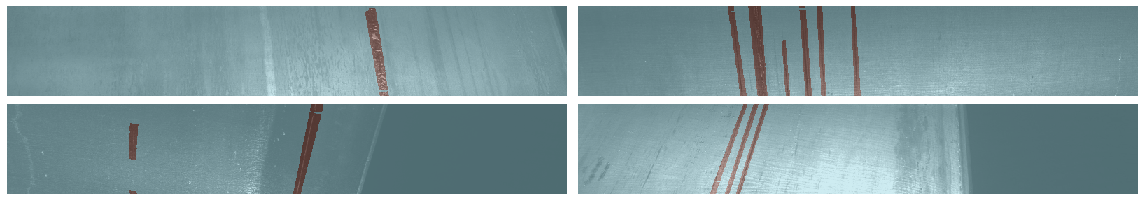

In [28]:
data.show_batch(2, figsize=(16,3))

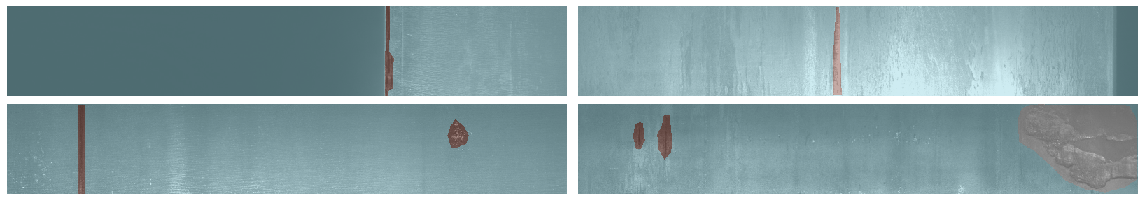

In [29]:
data.show_batch(2, figsize=(16,3),ds_type=DatasetType.Valid)

## Model

from: https://www.kaggle.com/nikhilikhar/fastai-steel-unet/notebook

In [30]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = 4
wd=1e-2

def acc_steel(input, target):
#     import pdb; pdb.set_trace()
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

def iou(input:Tensor, targs:Tensor) -> Rank0Tensor:
    "IoU coefficient metric for binary target."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input*targs).sum().float()
    union = (input+targs).sum().float()
    return intersect / (union-intersect+1.0)

metrics = [acc_steel, iou]

In [31]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True, 
                     model_dir="~/kaggle/working/models");

In [32]:
gc.collect()

24217

In [33]:
#lr_find(learn)
#learn.recorder.plot()

In [34]:
lr=3e-4
epoch = 10
learn.fit_one_cycle(epoch, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_steel,iou,time
0,0.147882,0.135527,0.485351,-2.039258,03:56
1,0.146027,0.118566,0.496321,-2.037448,03:55
2,0.135320,0.112045,0.514886,-2.037113,03:53
3,0.124546,0.116939,0.604619,-2.041735,03:53
4,0.112791,0.099246,0.553220,-2.035985,03:53
5,0.112482,0.109227,0.520117,-2.035843,03:53
6,0.121000,0.107027,0.667284,-2.040996,03:55
7,0.103975,0.092415,0.701484,-2.040383,03:54
8,0.099712,0.089222,0.654229,-2.037976,03:53
9,0.089717,0.081788,0.667143,-2.037393,03:54


In [36]:
learn.save('stage-1')
learn.export("~/kaggle/working/steel-1.pkl")

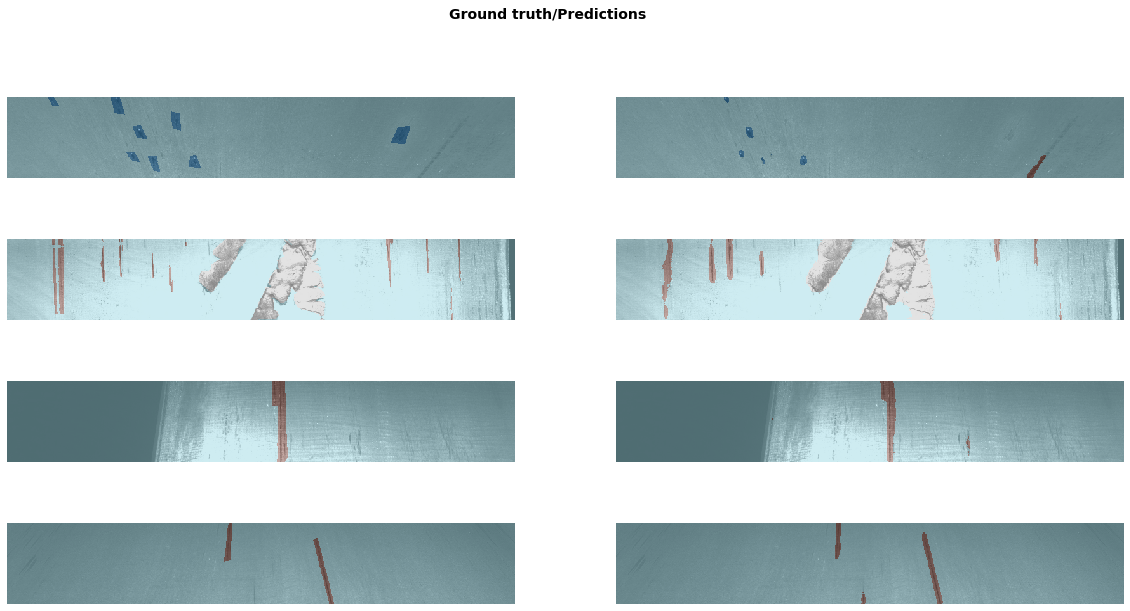

In [37]:
learn.show_results(ds_type=DatasetType.Train, rows=4, figsize=(20,10))

## **Test Set Predictions**

In [38]:
from itertools import groupby

def encode(input_string):
    return [(len(list(g)), k) for k,g in groupby(input_string)]

def run_length(label_vec):
    encode_list = encode(label_vec)
    index = 1
    class_dict = {}
    for i in encode_list:
        if i[1] != len(codes)-1:
            if i[1] not in class_dict.keys():
                class_dict[i[1]] = []
            class_dict[i[1]] = class_dict[i[1]] + [index, i[0]]
        index += i[0]
    return class_dict

In [39]:
test_df = pd.read_csv(data_folder / 'sample_submission.csv')
test_df.head()

,ImageId,EncodedPixels,ClassId
0,0000f269f.jpg,1 409600,0
1,000ccc2ac.jpg,1 409600,0
2,002451917.jpg,1 409600,0
3,003c5da97.jpg,1 409600,0
4,0042e163f.jpg,1 409600,0


In [40]:
from tqdm import tqdm, notebook

def get_predictions():
    results = []
    for index, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):

        img_name = row['ImageId']   
        img = open_image(test_images/img_name)
        pred = learn.predict(img)[1].data.numpy().flatten()
        class_dict = run_length(pred)

        for i in range(4):
            rle = ''
            if i in class_dict: rle = " ".join(map(str, class_dict[i]))
            results.append([img_name + "_" + str(i+1), rle])     
    return results
    
sub_list = get_predictions()   

100%|██████████| 5506/5506 [05:21<00:00, 17.13it/s]


In [41]:
# create the submission dataframe 
# - creating this in old format as having problems submitting in new format
submission_df = pd.DataFrame(sub_list, columns=['ImageId_ClassId', 'EncodedPixels'])
submission_df.head()

,ImageId_ClassId,EncodedPixels
0,0000f269f.jpg_1,41513 1 42313 1 43113 1
1,0000f269f.jpg_2,
2,0000f269f.jpg_3,288 10 1087 11 1888 10 2688 10 3488 10 4288 10...
3,0000f269f.jpg_4,
4,000ccc2ac.jpg_1,17535 1 18335 1 18337 1 19135 5 19935 4 20733 ...


In [42]:
submission_df.to_csv("submission.csv", index=False)